In [1]:
!rm -rf /content/midterm_folder

!pip install -q --upgrade gdown

!gdown --folder 1L_bSUw1yxUwZn0Ki3P8Z2BrFiiqpp2wi -O /content/midterm_folder --remaining-ok

Retrieving folder contents
Retrieving folder 1S-rq_GvoaZlhcteUrBd0XCF8K37i-uB8 test
Retrieving folder 1jehD2wUb7kN77JZUyW4CrZ7y9WmU8ir_ Bangus
Processing file 12keMV0x3dRWomO0xO_saxm6axsg-mtj_ Bangus 9.jpg
Processing file 1vuJ5hF04bh_TW9pZrV8q0m5rmxj9UC3o Bangus 19.jpg
Processing file 14fSuiAiWrFRPePNfTNXu3mlDjrVrh7ie Bangus 21.jpg
Processing file 1Ih0-Js6K7cV7DRfQKwPpgzgXmcktaejw Bangus 32.jpg
Processing file 1JTtJpMrCABWFQLJTz3-ozOdgzPP8cfpC Bangus 35.jpg
Processing file 1k82VNgxRDeqXKZrs8rrkak04oGXf3Kq6 Bangus 42.jpg
Processing file 1j0RjXiQHOyT4n79YSGdfNgVi3WmlvqHc Bangus 46.jpg
Processing file 1dThtxEAOjXI1StXTgiiS1C27w6h_kEsi Bangus 48.jpg
Processing file 1pm6Yu6AYiil6KNA9FCINKCuRf-FdCtuK Bangus 54.jpg
Processing file 1SYevo6RRjkeMn1ATfSo3qm-_zDDHMPDb Bangus 55.jpg
Processing file 1xYO2K-7zOLmUkFPAUO8eG8WoSUtQNFQF Bangus 62.jpg
Processing file 1Ji4E7AmFpJ123xWWKKoAd5LAYhpa1ijO Bangus 72.jpg
Processing file 1beQDqaETrIIO6W7BS_MynhKv7Yu6BkkE Bangus 76.jpg
Processing file 1zq5o9u2WV

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.listdir('/content/drive/MyDrive/FishImageDataset')

['val', 'train', 'test']

In [39]:
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D

In [5]:
BASE_DIR = "/content/drive/MyDrive/FishImageDataset"

TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

print("Train:", os.listdir(TRAIN_DIR))
print("Val:", os.listdir(VAL_DIR))
print("Test:", os.listdir(TEST_DIR))

Train: ['Tenpounder', 'Snakehead', 'Tilapia', 'Silver Barb', 'Silver Carp', 'Mullet', 'Silver Perch', 'Pangasius', 'Scat Fish', 'Perch', 'Mudfish', 'Janitor Fish', 'Mosquito Fish', 'Long-Snouted Pipefish', 'Knifefish', 'Jaguar Gapote', 'Grass Carp', 'Indian Carp', 'Green Spotted Puffer', 'Indo-Pacific Tarpon', 'Gold Fish', 'Fourfinger Threadfin', 'Gourami', 'Climbing Perch', 'Freshwater Eel', 'Goby', 'Catfish', 'Glass Perchlet', 'Black Spotted Barb', 'Big Head Carp', 'Bangus']
Val: ['Snakehead', 'Tenpounder', 'Tilapia', 'Scat Fish', 'Silver Carp', 'Silver Barb', 'Silver Perch', 'Perch', 'Pangasius', 'Mullet', 'Mosquito Fish', 'Janitor Fish', 'Mudfish', 'Indo-Pacific Tarpon', 'Indian Carp', 'Jaguar Gapote', 'Knifefish', 'Grass Carp', 'Green Spotted Puffer', 'Long-Snouted Pipefish', 'Gourami', 'Gold Fish', 'Climbing Perch', 'Goby', 'Glass Perchlet', 'Big Head Carp', 'Freshwater Eel', 'Fourfinger Threadfin', 'Black Spotted Barb', 'Catfish', 'Bangus']
Test: ['Tilapia', 'Tenpounder', 'Silve

In [6]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**preprocessing + augmentasi**

In [51]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 8801 images belonging to 31 classes.


In [11]:
val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 2751 images belonging to 31 classes.


In [12]:
test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 1760 images belonging to 31 classes.


**visualisasi sample image**

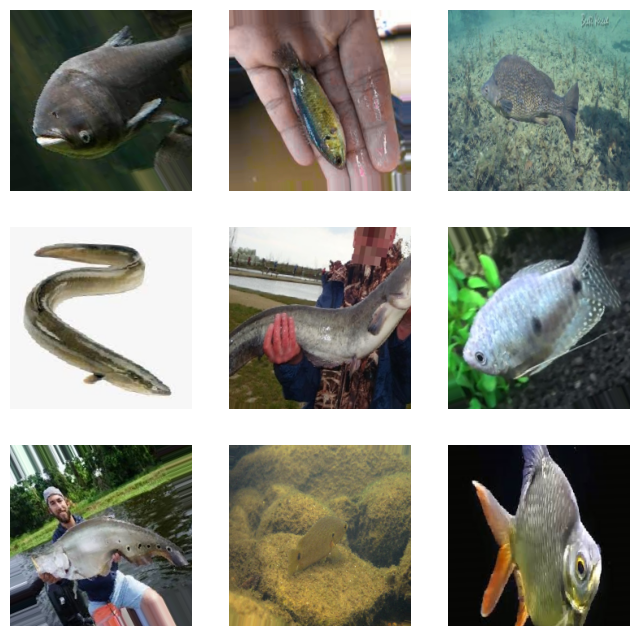

In [35]:
import matplotlib.pyplot as plt

images, labels = next(train_gen)

plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.axis("off")
plt.show()

**CNN from scratch**

In [13]:
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
cnn_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 54, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31)             │         3,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,173,343 (42.62 MB)

 Trainable params: 11,173,151 (42.62 MB)

 Non-trainable params: 192 (768.00 B)

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath='cnn_checkpoint.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [17]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=1e-6
    )
]

**train CNN model**

In [21]:
cnn_history = cnn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15
)

Epoch 1/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 174s 631ms/step - accuracy: 0.1585 - loss: 3.0875 - val_accuracy: 0.1832 - val_loss: 2.9582
Epoch 2/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 174s 629ms/step - accuracy: 0.1597 - loss: 3.0760 - val_accuracy: 0.1847 - val_loss: 2.9595
Epoch 3/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 175s 633ms/step - accuracy: 0.1512 - loss: 3.1008 - val_accuracy: 0.1868 - val_loss: 2.9619
Epoch 4/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 174s 630ms/step - accuracy: 0.1592 - loss: 3.0890 - val_accuracy: 0.1868 - val_loss: 2.9620
Epoch 5/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 174s 629ms/step - accuracy: 0.1614 - loss: 3.0645 - val_accuracy: 0.1854 - val_loss: 2.9599
Epoch 6/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 174s 630ms/step - accuracy: 0.1605 - loss: 3.0782 - val_accuracy: 0.1839 - val_loss: 2.9601
Epoch 7/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 172s 623ms/step - accuracy: 0.1598 - loss: 3.0670 - val_accuracy: 0.1836 - val_loss: 2.9589
Epoch 8/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 174s 630ms/step - accuracy: 0.1579 -

**evaluasi cnn**

In [36]:
val_gen.reset()
pred = cnn_model.predict(val_gen)
y_pred = np.argmax(pred, axis=1)

print(classification_report(
    val_gen.classes,
    y_pred,
    target_names=class_names
))

86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 225ms/step
                       precision    recall  f1-score   support

               Bangus       0.00      0.00      0.00        52
        Big Head Carp       0.00      0.00      0.00        63
   Black Spotted Barb       0.00      0.00      0.00        63
              Catfish       0.00      0.00      0.00        97
       Climbing Perch       0.00      0.00      0.00        48
 Fourfinger Threadfin       0.00      0.00      0.00        60
       Freshwater Eel       0.00      0.00      0.00        84
       Glass Perchlet       0.00      0.00      0.00       124
                 Goby       0.07      0.72      0.13       189
            Gold Fish       0.00      0.00      0.00        65
              Gourami       0.00      0.00      0.00        97
           Grass Carp       0.14      0.29      0.19       378
 Green Spotted Puffer       0.00      0.00      0.00        34
          Indian Carp       0.00      0.00      0.00        81
  Indo-Pacif

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**confusion matrix**

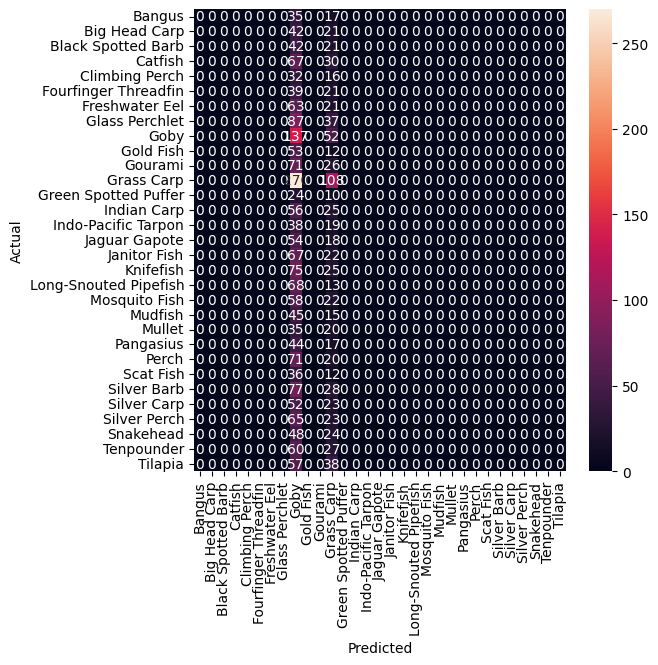

In [40]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(val_gen.classes, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**transfer learning**

In [27]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [28]:
tl_model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])

In [29]:
tl_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

tl_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     8,028,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 31)             │         3,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,290,271 (39.25 MB)

 Trainable params: 8,032,287 (30.64 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

**train transfer learning model**

In [30]:
tl_history = tl_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

Epoch 1/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 215s 720ms/step - accuracy: 0.1913 - loss: 3.1168 - val_accuracy: 0.5991 - val_loss: 1.5879
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 175s 634ms/step - accuracy: 0.4234 - loss: 2.0577 - val_accuracy: 0.7023 - val_loss: 1.2404
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 175s 633ms/step - accuracy: 0.5060 - loss: 1.7641 - val_accuracy: 0.7644 - val_loss: 0.9314
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 176s 637ms/step - accuracy: 0.5759 - loss: 1.5066 - val_accuracy: 0.7935 - val_loss: 0.8240
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 175s 633ms/step - accuracy: 0.5931 - loss: 1.4292 - val_accuracy: 0.8132 - val_loss: 0.7673
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 172s 624ms/step - accuracy: 0.6270 - loss: 1.2658 - val_accuracy: 0.8277 - val_loss: 0.6472
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 172s 624ms/step - accuracy: 0.6354 - loss: 1.2639 - val_accuracy: 0.8637 - val_loss: 0.5555
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 173s 627ms/step - accuracy: 0.6590 -

**evaluasi model/test data**

In [33]:
import numpy as np
from sklearn.metrics import classification_report

test_gen.reset()
y_pred = tl_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

print(classification_report(y_true, y_pred_classes, target_names=class_names))

55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 263ms/step
                       precision    recall  f1-score   support

               Bangus       0.88      0.68      0.77        34
        Big Head Carp       0.86      0.72      0.78        43
   Black Spotted Barb       0.83      0.50      0.62        40
              Catfish       0.87      0.89      0.88        62
       Climbing Perch       1.00      0.40      0.57        30
 Fourfinger Threadfin       0.81      0.79      0.80        38
       Freshwater Eel       0.81      0.93      0.86        55
       Glass Perchlet       0.75      0.99      0.85        77
                 Goby       0.79      0.94      0.86       124
            Gold Fish       0.95      1.00      0.98        41
              Gourami       0.92      0.94      0.93        63
           Grass Carp       0.94      0.96      0.95       238
 Green Spotted Puffer       1.00      0.95      0.98        22
          Indian Carp       0.85      0.96      0.90        53
  Indo-Pacif

**confusion matrix visualization**

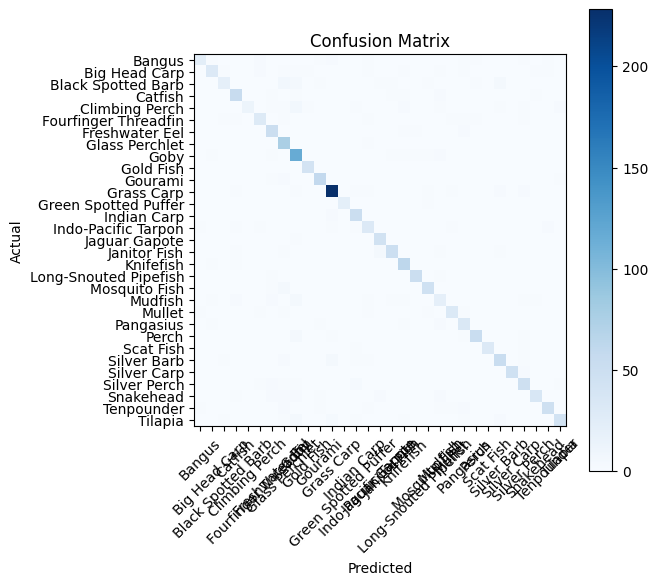

In [42]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6,6))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**test set**

In [52]:
test_gen.reset()
preds = tl_model.predict(test_gen)
pred_classes = np.argmax(preds, axis=1)

for i, cls in enumerate(pred_classes):
    print(f"Image {i+1} → Predicted: {class_names[cls]}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 293ms/step
Image 1 → Predicted: Bangus
Image 2 → Predicted: Silver Perch
Image 3 → Predicted: Bangus
Image 4 → Predicted: Bangus
Image 5 → Predicted: Bangus
Image 6 → Predicted: Gourami
Image 7 → Predicted: Tenpounder
Image 8 → Predicted: Big Head Carp
Image 9 → Predicted: Indo-Pacific Tarpon
Image 10 → Predicted: Bangus
Image 11 → Predicted: Bangus
Image 12 → Predicted: Bangus
Image 13 → Predicted: Bangus
Image 14 → Predicted: Bangus
Image 15 → Predicted: Fourfinger Threadfin
Image 16 → Predicted: Bangus
Image 17 → Predicted: Bangus
Image 18 → Predicted: Perch
Image 19 → Predicted: Bangus
Image 20 → Predicted: Bangus
Image 21 → Predicted: Bangus
Image 22 → Predicted: Grass Carp
Image 23 → Predicted: Bangus
Image 24 → Predicted: Fourfinger Threadfin
Image 25 → Predicted: Bangus
Image 26 → Predicted: Bangus
Image 27 → Predicted: Bangus
Image 28 → Predicted: Bangus
Image 29 → Predicted: Pangasius
Image 30 → Predicted: Bangus
Image 31 → Predicted: Bangus
Ima

In [47]:
tl_model.save("cnn_image_classification_model.h5")
print("Model berhasil disimpan")

Model berhasil disimpan


**visualisasi akurasi dan loss**

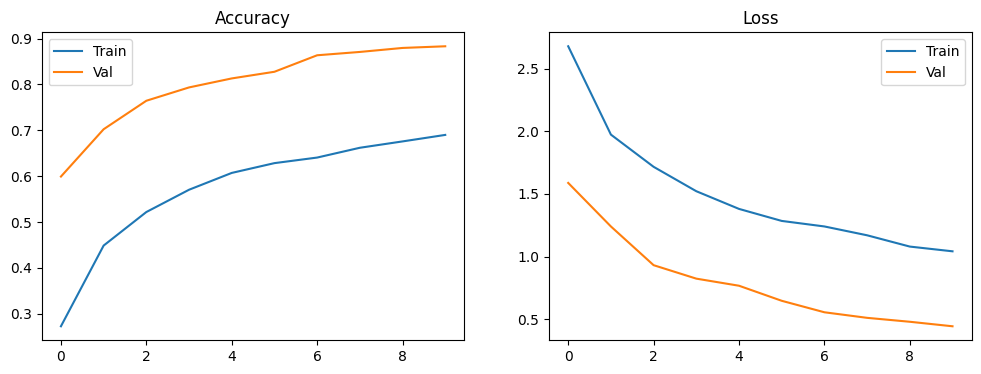

In [54]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(tl_history.history['accuracy'], label='Train')
plt.plot(tl_history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(tl_history.history['loss'], label='Train')
plt.plot(tl_history.history['val_loss'], label='Val')
plt.title("Loss")
plt.legend()

plt.show()

**visualisasi hasil training**

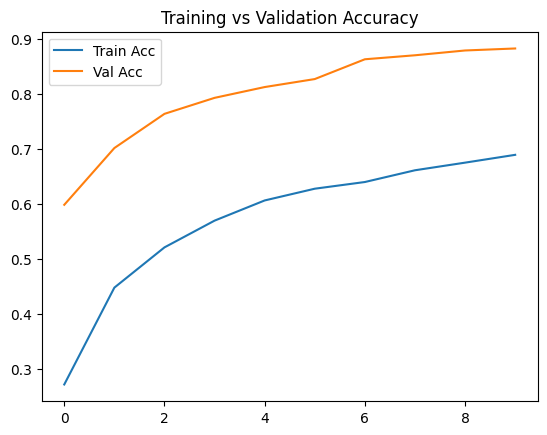

In [43]:
plt.plot(tl_history.history['accuracy'], label='Train Acc')
plt.plot(tl_history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

**validation accuracy**

In [48]:
test_loss, test_acc = tl_model.evaluate(test_gen)
print("Test Accuracy:", test_acc)

55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 239ms/step - accuracy: 0.8356 - loss: 0.5804
Test Accuracy: 0.8727272748947144


In [49]:
print(f"Test Accuracy: {test_acc*100:.2f}%")

Test Accuracy: 87.27%


**perbandingan model cnn dan transfer learning**

In [56]:
cnn_acc = max(cnn_history.history['val_accuracy'])
tl_acc  = max(tl_history.history['val_accuracy'])

print("CNN Validation Accuracy:", cnn_acc)
print("Transfer Learning Validation Accuracy:", tl_acc)

if tl_acc > cnn_acc:
    print("Transfer Learning performs better than CNN from scratch")
else:
    print("CNN from scratch performs better")

CNN Validation Accuracy: 0.18684114515781403
Transfer Learning Validation Accuracy: 0.8833151459693909
Transfer Learning performs better than CNN from scratch


model mampu mengklasifikasikan sebagian besar data uji dengan benar, yang ditandai oleh dominasi nilai pada diagonal utama. Kesalahan klasifikasi yang terjadi relatif kecil dan umumnya disebabkan oleh kemiripan karakteristik antar kelas. Hasil ini diperkuat dengan nilai test accuracy sebesar 87,27%, yang menandakan bahwa model memiliki performa dan kemampuan generalisasi yang baik